In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymysql
import pyneb as pn
%matplotlib inline

In [2]:
try:
    import ai4neb
except:
    !pip install -U git+https://github.com/morisset/AI4neb.git
    import ai4neb

2023-08-11 17:59:04.097197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/christophemorisset/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import tensorflow

In [4]:
print(tensorflow.__version__)

2.0.0


In [ ]:
dir_ = 'RMs/'

In [5]:
print('Elem.  IP_II IP_III  IP_IV  IP_V')
pn.print_IPs(N_elems=18, N_ions=4)

Elem.  IP_II IP_III  IP_IV  IP_V
H      13.60
He     24.59  54.42
Li      5.39  75.64 122.45
Be      9.32  18.21 153.90 217.72
B       8.30  25.15  37.93 259.37
C      11.26  24.38  47.89  64.49
N      14.53  29.60  47.45  77.47
O      13.62  35.12  54.94  77.41
F      17.42  34.97  62.71  87.17
Ne     21.56  40.96  63.42  97.19
Na      5.14  47.29  71.62  98.94
Mg      7.65  15.04  80.14 109.27
Al      5.99  18.83  28.45 119.99
Si      8.15  16.35  33.49  45.14
P      10.49  19.77  30.20  51.44
S      10.36  23.34  34.86  47.22
Cl     12.97  23.81  39.80  53.24
Ar     15.76  27.63  40.73  59.58


In [6]:
ar2 = pn.Atom

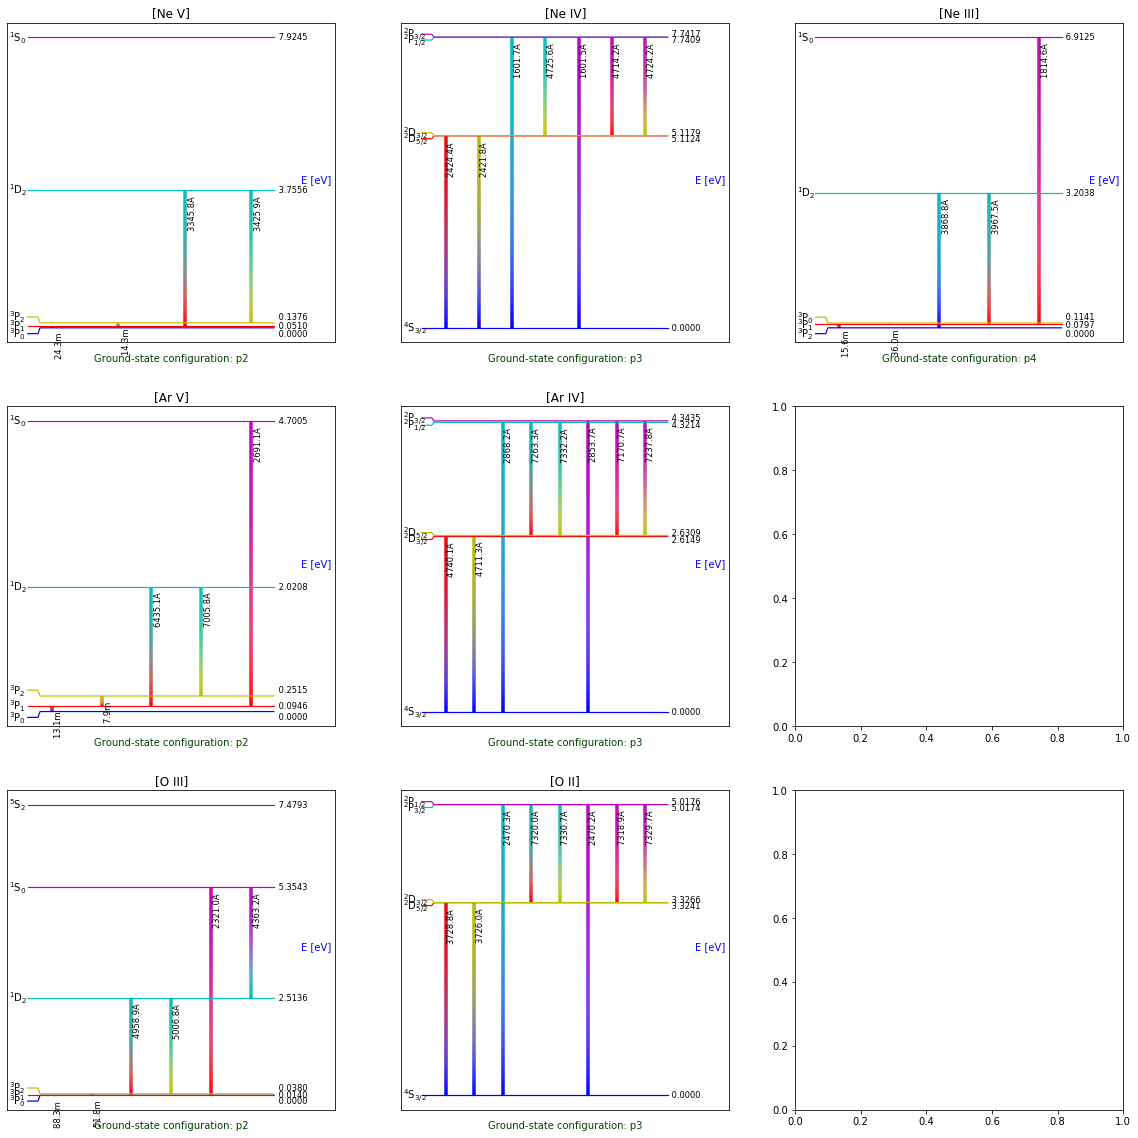

In [7]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20,20))

pn.Atom('Ne',5,NLevels=5).plotGrotrian(ax=ax1)
pn.Atom('Ne',4,NLevels=5).plotGrotrian(ax=ax2)
pn.Atom('Ne',3).plotGrotrian(ax=ax3)

pn.Atom('Ar',5,NLevels=5).plotGrotrian(ax=ax4)
pn.Atom('Ar',4).plotGrotrian(ax=ax5)

pn.Atom('O',3,NLevels=6).plotGrotrian(ax=ax7)
pn.Atom('O',2,NLevels=5).plotGrotrian(ax=ax8)


## Download data from 3MdB_17 with ref = PNe and com6 = 1

In [83]:
use_17 = True
if use_17:
    sel="""select
        tab_17.ref, tab_17.N, com1, com6, log10(atm1) as logTeff, massfrac, oxygen, dens, logU_mean, THp, 
        NE_5_342603A as ne5 , BLND_472000A as ne4, NE_3_386876A as ne3, 
        AR_5_643512A as ar5, AR_4_474012A as ar4,
        O__3_500684A as o3, BLND_372700A  as o2, BLND_436300A as o3_63,
        HE_1_587564A as he1, HE_2_468564A as he2, H__1_486133A as hb,
        CA_B_486133A as hb_b, CA_B_468564A as he2_b,
        A_HELIUM_vol_2 as he_pp
        FROM tab_17, abion_17
        WHERE tab_17.N = abion_17.N AND tab_17.ref = 'PNe_2020' """

    db = pymysql.connect(host=os.environ['MdB_HOST'], 
                         user=os.environ['MdB_USER'], 
                         passwd=os.environ['MdB_PASSWD'], 
                         db='3MdB_17')    
    
else:
    sel="""select
        tab.ref, com1, com6, log10(atm1) as logTeff, massfrac, oxygen, dens, logU_mean, 
        NE_5__3426A as ne5 , NE_4__4720A as ne4, NE_3__3968A + NE_3__3869A as ne3, 
        AR_5__7005A as ar5, AR_4__4740A as ar4,
        O__3__5007A as o3, TOTL__3727A  as o2, TOTL__4363A as o3_63,
        HE_1__5876A as he1, HE_2__4686A as he2, H__1__4861A as hb
        FROM tab
        WHERE tab.ref LIKE 'PNe_%' AND com6=1 """

    db = pymysql.connect(host=os.environ['MdB_HOST'], 
                         user=os.environ['MdB_USER'], 
                         passwd=os.environ['MdB_PASSWD'], 
                         db=os.environ['MdB_DBp'])    



res = pd.read_sql(sel, con=db)
db.close()

In [57]:
print(len(res))

482465


Define a plotting routine

In [19]:
def plot_RM(RM):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 14))
    RM.plot_loss(ax=ax1)
    
    dif = RM.pred.ravel() - RM.y_test_ori[RM.isfin,0].ravel()
    ax2.hist(dif, bins=np.arange(-.15, .15, .005))
    ax2.set_title('median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
    ax2.set_xlabel('Pred - True')
    ax2.set_xlim((-.15,.15))
    
    ax3.scatter(RM.y_test_ori[RM.isfin,0], RM.pred, alpha=0.1, marker='.')
    #ax3.scatter(RM.pred, RM.pred, c='r', marker='.')
    ax3.plot([np.min(RM.pred), np.max(RM.pred)], [np.min(RM.pred), np.max(RM.pred)], c='r')
    ;    

### Define, train and use a neural network. Use HeI/Hb and HeII/Hb as X.

In [44]:
RM4 = ai4neb.manage_RM(RM_type='K_ANN',
                       X_train=np.array((res['he1']/res['hb'], 
                                         res['he2']/res['hb'])).T, 
                       y_train=res['logTeff'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=42,
                       split_ratio=0.3, 
                       clear_session=True)
RM4.init_RM(hidden_layer_sizes=(50,50, 30),# dropout=(0.0, 0.3), 
            activation='tanh',
            solver='adam',epochs=300)
RM4.train_RM()
RM4.predict()
RM4.save_RM(dir_ + 'yTeff-XHe1He2')

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 49607, Test set size = 21261
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 49607, Test set size = 21261
Training set size = 49607, Test set size = 21261
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 4,261
Trainable params: 4,261
Non-tra

### Plot the result. Not very good in determining Teff

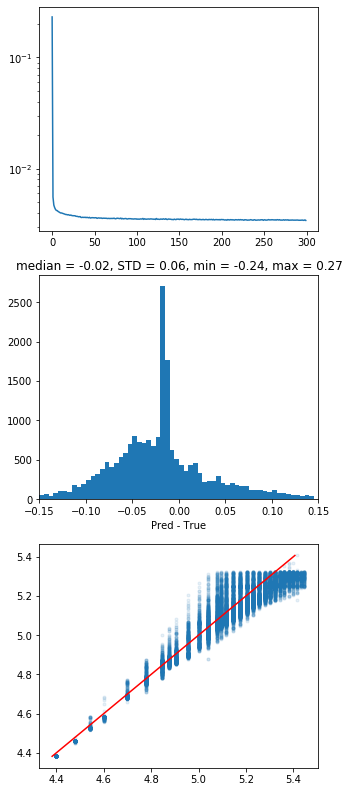

In [11]:
plot_RM(RM4)

### Do the same, but adding OIII/OII, ArV/ArIV and NeIV/NeIII to the X.

In [48]:
RM = ai4neb.manage_RM(RM_type='K_ANN',
                       X_train=np.array((res['he1']/res['hb'], 
                                         res['he2']/res['hb'], 
                                         res['o3']/res['o2'],
                                         res['ar5']/res['ar4'],
                                         res['ne4']/res['ne3'])).T, 
                       y_train=res['logTeff'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=42,
                       split_ratio=0.3, 
                       clear_session=True)
RM.init_RM(hidden_layer_sizes=(50,50, 30),# dropout=(0.0, 0.3), 
            activation='tanh',
            solver='adam',epochs=300)
RM.train_RM()
RM.predict()
RM.save_RM(dir_ + 'yTeff-XHe1He2O32Ar54Ne43')

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 49607, Test set size = 21261
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 49126, Test set size = 21061
Training set size = 49126, Test set size = 21061


/Users/christophemorisset/Google Drive/Pro/AI/mwinai/Regressor/RegressionModel.py:500: RuntimeWarning: divide by zero encountered in log10
  X = np.log10(X)
/Users/christophemorisset/Google Drive/Pro/AI/mwinai/Regressor/RegressionModel.py:500: RuntimeWarning: divide by zero encountered in log10
  X = np.log10(X)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 4,411
Trainable params: 4,411
Non-trainable params: 0
_________________________________________________________________
Regression Model K_ANN
Training 5 inputs for 1 outputs with 49126 data
RM trained. Score = 0.989
Training time 739.5 s.
Predicting from 5 inputs to 1 outputs using 21061 data in 0.33 secs.
RM save to yTeff-XHe1He2O32Ar54Ne43.mwinai_k0
RM save to yTeff-

### Very better predictions. High Teff are not well constraint, high IPs ions needed.

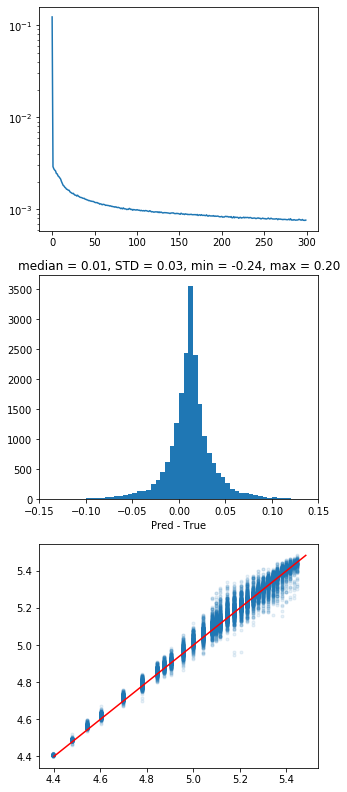

In [49]:
plot_RM(RM)

### The same but with Scikit Learn package

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 56694, Test set size = 14174
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 56694, Test set size = 14174
Training set size = 56694, Test set size = 14174
Regression Model SK_ANN
Training 2 inputs for 1 outputs with 56694 data
RM trained, with 71 iterations. Score = 0.951
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 50, 30), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='adam', tol=1e-07,
             validation_fraction=0.1, verbose=False, warm_start=False)
Training time 21.7 s.
Predicting from 2 inputs to 1 ou

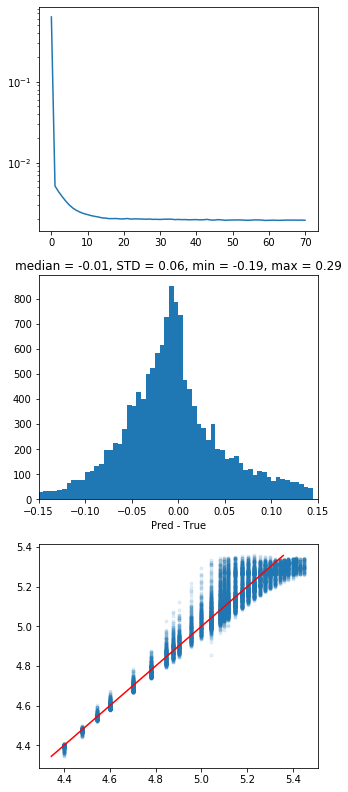

In [42]:
RM3 = ai4neb.manage_RM(RM_type='SK_ANN',
                       X_train=np.array((res['he1']/res['hb'], 
                                         res['he2']/res['hb'])).T, 
                       y_train=res['logTeff'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=42,
                       split_ratio=0.2, 
                       clear_session=True)
RM3.init_RM(hidden_layer_sizes=(50,50, 30),
            activation='tanh',
            solver='adam',tol=1e-7, max_iter=500)
RM3.train_RM()
RM3.predict()
RM3.save_RM(dir_ + 'yTeff-XHe1He2_S')
plot_RM(RM3)

### Adding only OIII/OII to He lines

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 56694, Test set size = 14174
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 56694, Test set size = 14174
Training set size = 56694, Test set size = 14174
Regression Model SK_ANN
Training 3 inputs for 1 outputs with 56694 data
RM trained, with 179 iterations. Score = 0.973
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 50, 30), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='adam', tol=1e-07,
             validation_fraction=0.1, verbose=False, warm_start=False)
Training time 53.8 s.
Predicting from 3 inputs to 1 o

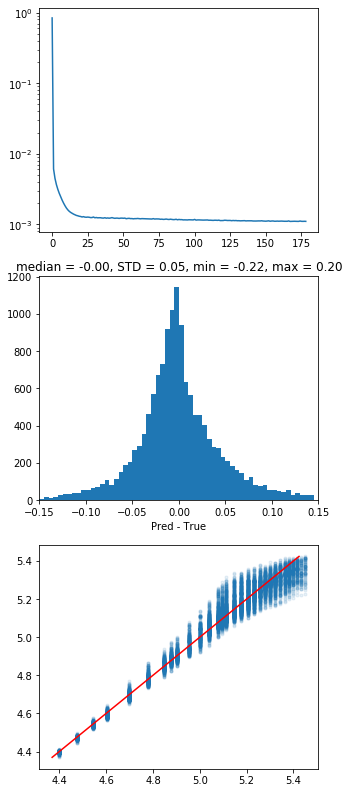

In [41]:
RM2 = ai4neb.manage_RM(RM_type='SK_ANN',
                       X_train=np.array((res['he1']/res['hb'], 
                                         res['he2']/res['hb'], 
                                         res['o3']/res['o2'])).T, 
                       y_train=res['logTeff'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=42,
                       split_ratio=0.2, 
                       clear_session=True)
RM2.init_RM(hidden_layer_sizes=(50,50, 30), 
            activation='tanh',
            solver='adam',tol=1e-7, max_iter=500)
RM2.train_RM()
RM2.predict()
RM2.save_RM(dir_ + 'yTeff-XHe1He2O32_S')
plot_RM(RM2)

### With the 5 line ratios

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 56694, Test set size = 14174
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 56153, Test set size = 14034
Training set size = 56153, Test set size = 14034
Regression Model SK_ANN
Training 5 inputs for 1 outputs with 56153 data


/Users/christophemorisset/Google Drive/Pro/AI/mwinai/Regressor/RegressionModel.py:500: RuntimeWarning: divide by zero encountered in log10
  X = np.log10(X)
/Users/christophemorisset/Google Drive/Pro/AI/mwinai/Regressor/RegressionModel.py:500: RuntimeWarning: divide by zero encountered in log10
  X = np.log10(X)


RM trained, with 333 iterations. Score = 0.988
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 50, 30), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='adam', tol=1e-07,
             validation_fraction=0.1, verbose=False, warm_start=False)
Training time 102.7 s.
Predicting from 5 inputs to 1 outputs using 14034 data in 0.02 secs.
RM save to yTeff-XHe1He2O32Ar54Ne43_S.mwinai_sk


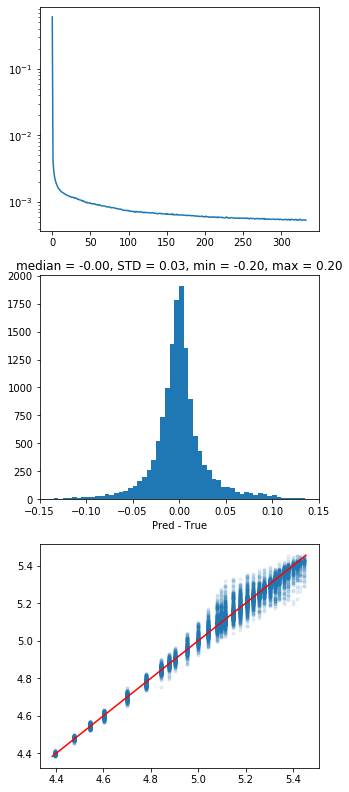

In [43]:
RM5 = ai4neb.manage_RM(RM_type='SK_ANN',
                       X_train=np.array((res['he1']/res['hb'], 
                                         res['he2']/res['hb'], 
                                         res['o3']/res['o2'],
                                         res['ar5']/res['ar4'],
                                         res['ne4']/res['ne3'])).T, 
                       y_train=res['logTeff'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=42,
                       split_ratio=0.2, 
                       clear_session=True)
RM5.init_RM(hidden_layer_sizes=(50,50, 30), 
            activation='tanh',
            solver='adam',tol=1e-7, max_iter=500)
RM5.train_RM()
RM5.predict()
RM5.save_RM(dir_ + 'yTeff-XHe1He2O32Ar54Ne43_S')
plot_RM(RM5)

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 56694, Test set size = 14174
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 53433, Test set size = 13350
Training set size = 53433, Test set size = 13350
Regression Model SK_ANN
Training 5 inputs for 1 outputs with 53433 data


/Users/christophemorisset/Google Drive/Pro/AI/mwinai/Regressor/RegressionModel.py:500: RuntimeWarning: divide by zero encountered in log10
  X = np.log10(X)
/Users/christophemorisset/Google Drive/Pro/AI/mwinai/Regressor/RegressionModel.py:500: RuntimeWarning: divide by zero encountered in log10
  X = np.log10(X)


RM trained, with 258 iterations. Score = 0.988
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 50, 30), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='adam',
             tol=1e-07, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 59.2 s.
Predicting from 5 inputs to 1 outputs using 13350 data in 0.03 secs.
RM save to yTeff-XHe1He2O32Ar54Ne53_S.mwinai_sk


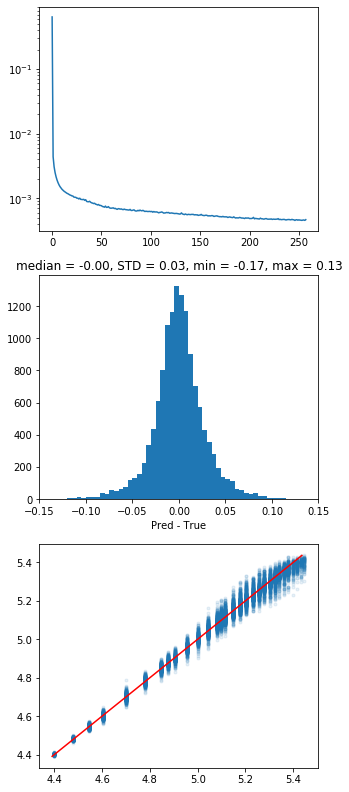

In [109]:
RM6 = ai4neb.manage_RM(RM_type='SK_ANN',
                       X_train=np.array((res['he1']/res['hb'], 
                                         res['he2']/res['hb'], 
                                         res['o3']/res['o2'],
                                         res['ar5']/res['ar4'],
                                         res['ne5']/res['ne3'])).T, 
                       y_train=res['logTeff'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=42,
                       split_ratio=0.2, 
                       clear_session=True)
RM6.init_RM(hidden_layer_sizes=(50, 50, 30), 
            activation='tanh',
            solver='adam',tol=1e-7, max_iter=500)
RM6.train_RM()
RM6.predict()
RM6.save_RM(dir_ + 'yTeff-XHe1He2O32Ar54Ne53_S')
plot_RM(RM6)

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 56694, Test set size = 14174
Discretizing column 0 on 20 bins
Discretizing column 0 on 20 bins
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 53433, Test set size = 13350
Training set size = 53433, Test set size = 13350
Regression Model SK_ANN_Dis
Training 5 inputs for 20 outputs with 53433 data


/Users/christophemorisset/Google Drive/Pro/AI/mwinai/Regressor/RegressionModel.py:500: RuntimeWarning: divide by zero encountered in log10
  X = np.log10(X)
/Users/christophemorisset/Google Drive/Pro/AI/mwinai/Regressor/RegressionModel.py:500: RuntimeWarning: divide by zero encountered in log10
  X = np.log10(X)


RM trained, with 739 iterations. Score = 0.693
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 50, 100), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='adam',
             tol=1e-08, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 243.1 s.
Reducing y by max
Predicting from 5 inputs to 20 outputs using 13350 data in 0.05 secs.
RM save to yTeff-XHe1He2O32Ar54Ne53_Sd.mwinai_sk


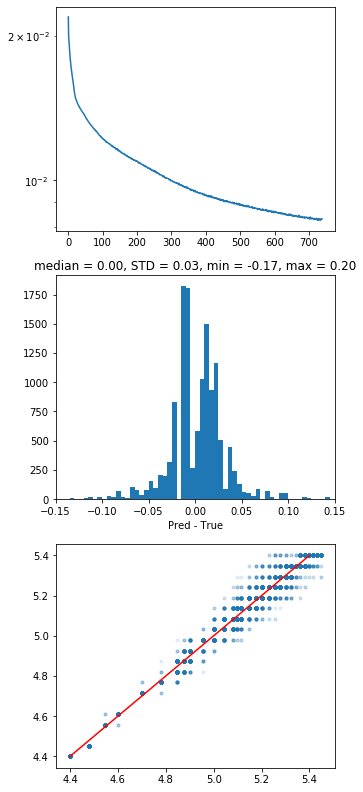

In [20]:
y_vects = np.linspace(4.4, 5.4, 20)
RM6d = ai4neb.manage_RM(RM_type='SK_ANN_Dis',
                       X_train=np.array((res['he1']/res['hb'], 
                                         res['he2']/res['hb'], 
                                         res['o3']/res['o2'],
                                         res['ar5']/res['ar4'],
                                         res['ne5']/res['ne3'])).T, 
                       y_train=res['logTeff'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=42,
                       split_ratio=0.2, 
                       clear_session=True, 
                        y_vects=y_vects)
RM6d.init_RM(hidden_layer_sizes=(50, 50, 100), 
            activation='tanh',
            solver='adam',tol=1e-8, max_iter=1500)
RM6d.train_RM()
RM6d.predict()
RM6d.pred_full = RM6d.pred
RM6d.predict(reduce_by='max')
RM6d.pred_max = RM6d.pred
RM6d.predict(reduce_by='mean')
RM6d.pred_mean = RM6d.pred
RM6d.save_RM(dir_ + 'yTeff-XHe1He2O32Ar54Ne53_Sd')
plot_RM(RM6d)

Predicting from 5 inputs to 20 outputs using 13350 data in 0.06 secs.
Reducing y by max
Predicting from 5 inputs to 20 outputs using 13350 data in 0.06 secs.
Reducing y by mean
Predicting from 5 inputs to 20 outputs using 13350 data in 0.04 secs.


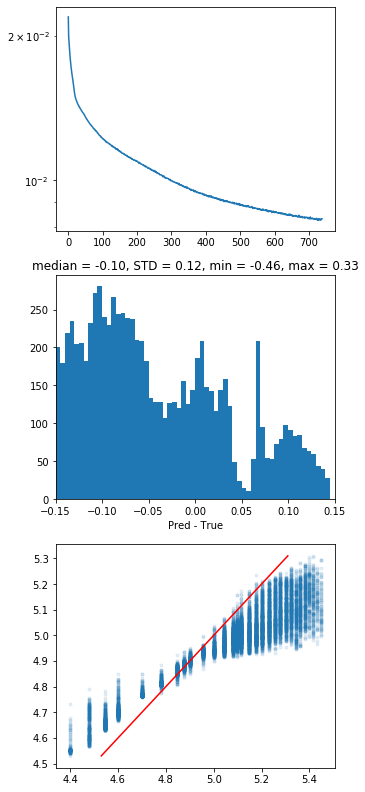

In [80]:
RM6d.predict()
RM6d.pred_full = RM6d.pred
RM6d.pred_mean2 = np.dot(RM6d.pred_full,RM6d.y_vects)
RM6d.predict(reduce_by='max')
RM6d.pred_max = RM6d.pred
RM6d.predict(reduce_by='mean')
RM6d.pred_mean = RM6d.pred
plot_RM(RM6d)

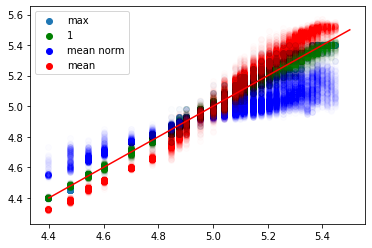

In [135]:
f, ax = plt.subplots()
X = RM6d.y_test_ori[RM6d.isfin,0]
ax.scatter(X, RM6d.pred_max, alpha=0.01, label='max')
ax.scatter(X, RM6.pred, alpha=0.01, c='g', label='1')
ax.scatter(X, RM6d.pred_mean, alpha=0.01, c='b', label='mean norm')
ax.scatter(X, RM6d.pred_mean2, alpha=0.01, c='r', label='mean')
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.plot([4.4, 5.5], [4.4, 5.5], c='r');

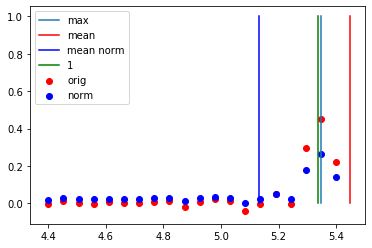

In [137]:
ind = np.where((RM6d.pred_max - RM6d.pred_mean) > 0.2)[0][32]
f, ax = plt.subplots()
ax.scatter(y_vects, RM6d.pred_full[ind,:], c='r',label='orig')
ax.scatter(y_vects, RM6d.pred_norm[ind,:], c='b',label='norm')
ax.plot((RM6d.pred_max[ind], RM6d.pred_max[ind]), (0, 1), label='max')
ax.plot((RM6d.pred_mean2[ind], RM6d.pred_mean2[ind]), (0, 1), label='mean', c='r')
ax.plot((RM6d.pred_mean[ind], RM6d.pred_mean[ind]), (0, 1), label='mean norm', c='b')
ax.plot((RM6.pred[ind], RM6.pred[ind]), (0, 1), label='1', c='g')
ax.legend();

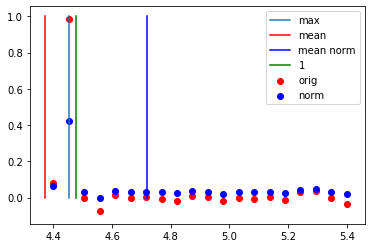

In [138]:
ind = np.where((RM6d.pred_max - RM6d.pred_mean) < -0.2)[0][32]
f, ax = plt.subplots()
ax.scatter(y_vects, RM6d.pred_full[ind,:], c='r',label='orig')
ax.scatter(y_vects, RM6d.pred_norm[ind,:], c='b',label='norm')
ax.plot((RM6d.pred_max[ind], RM6d.pred_max[ind]), (0, 1), label='max')
ax.plot((RM6d.pred_mean2[ind], RM6d.pred_mean2[ind]), (0, 1), label='mean', c='r')
ax.plot((RM6d.pred_mean[ind], RM6d.pred_mean[ind]), (0, 1), label='mean norm', c='b')
ax.plot((RM6.pred[ind], RM6.pred[ind]), (0, 1), label='1', c='g')
ax.legend();